In [1]:
import json
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from transformers import AutoTokenizer, AutoModel
import torch
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import Levenshtein
from itertools import islice

/home/dayouwu2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
testing_input_pickle = pd.read_pickle("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_wbart_testing.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_wbart_testing.pkl'

In [10]:
print(testing_input_pickle.head())

    author      msg   timestamp  \
0  1757901  1757903  1672534632   
1  1757926  1757927  1672534518   
2  1757943  1757945  1672534447   
3  1757972  1757974  1672533731   
4  1758002  1758004  1672533679   

                                         contentText  concern_bart-phillipine  \
0  @UnkleFlip @TSingletonSays @SportsVix O shit…d...                 0.031723   
1  @GrantCardone Oops, my finger hit CDC it shoul...                 0.008754   
2  RT @timand2037 RT. #Türkiye has agreed to full...                 0.121434   
3  RT @ItsDanSheehan You say NPC like it's a bad ...                 0.061782   
4  RT @libbyliberalnyc "(Shittin' On) The Dock of...                 0.010799   

   concern_bart-china  concern_bart-united states  concern_bart-refugees  \
0            0.000889                    0.061526               0.011795   
1            0.000213                    0.006890               0.000416   
2            0.001188                    0.004340               0.013564  

In [13]:
def format_converter(input_pickle, output_pickle, filter, mapping):
    df = pd.read_pickle(input_pickle)
    filtered_df = df[filter]
    renamed_df = filtered_df.rename(columns = mapping)
    renamed_df.to_pickle(output_pickle)
    return True

In [14]:
filter = ['author', 'timestamp', 'contentText']
mapping = {'author':'name', 'timestamp':'time_published', 'contentText':'rawTweet'}
input_pickle = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/2a_wtext_wbart_testing.pkl"
output_pickle = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/testing_input.pkl"
format_converter(input_pickle, output_pickle, filter, mapping)

True

In [2]:
def dataset_spliter(input_pickle, savingPath_train, savingPath_test):
    df = pd.read_pickle(input_pickle)
    df_sorted = df.sort_values(by='time_published')
    train_set, test_set = train_test_split(df_sorted, test_size=0.1, shuffle=False)
    train_set.to_pickle(savingPath_train)

    time_first = train_set.iloc[0]['time_published']

    test_set.to_pickle(savingPath_test)

    time_last = test_set.iloc[-1]['time_published']

    return time_first, time_last

In [3]:
def cluster_active_map(input_pickle, hashtag_clusters_path, time_start, time_last):
    with open(hashtag_clusters_path, 'r') as f:
        hashtag_clusters = json.load(f)
    element_to_cluster = {element: cluster_id for cluster_id, elements in hashtag_clusters.items() for element in elements}

    df = pd.read_pickle(input_pickle)
    cluster_active_map = np.zeros((50, 10))
    time_gap = time_last - time_start + 1

    for index, row in tqdm(df.iterrows()):
        rawTweet = row['rawTweet']
        hashtags = set(x for x in rawTweet.split() if x.startswith('#'))
        time = row['time_published']
        time_diff = time - time_start

        time_range =  int(time_diff *10/time_gap)

        for hashtag in hashtags:
            cluster_id = element_to_cluster.get(hashtag, None)
            if cluster_id:
                c_id = int(cluster_id)
                cluster_active_map[c_id][time_range] += 1
    
    np.save("cluster_active_map.npy", cluster_active_map)
    pass

In [4]:
savingPath_train = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_eval_train.pkl"
savingPath_test = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_eval_test.pkl"
time_first, time_last = dataset_spliter("/home/dayouwu2/event_detection/event_detection_twitter/artifact_dir/temp_output/input_file.pkl", savingPath_train, savingPath_test)
print(time_first, time_last)

1693526714 1698883198


In [12]:
cluster_active_map("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/testing_input.pkl", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/hashtag_clusters.json", time_first_, time_last_)

4726147it [04:01, 19592.12it/s]


In [13]:
cluster_active_map = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/cluster_active_map.npy")

In [28]:
print(cluster_active_map[])

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  2.21300e+03 1.24600e+03 3.77000e+02 6.27000e+02]
 [4.57000e+02 3.46000e+02 7.02000e+02 8.12000e+02 5.16000e+02 1.07965e+05
  2.51082e+05 1.00825e+05 6.81960e+04 1.17641e+05]
 [5.00000e+00 0.00000e+00 2.00000e+00 4.00000e+00 0.00000e+00 5.41100e+03
  4.19300e+03 3.53600e+03 5.37900e+03 4.56500e+03]
 [2.30000e+01 3.00000e+01 4.90000e+01 2.90000e+01 9.00000e+00 4.40000e+01
  1.72400e+03 1.75700e+03 3.66500e+03 1.60540e+04]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.76000e+02
  2.57700e+03 6.20000e+01 1.20000e+01 2.00000e+01]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e+00
  5.18600e+03 2.91120e+04 4.38600e+03 6.19500e+03]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.95100e+03
  1.07000e+03 2.30000e+01 1.50000e+01 1.30000e+01]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.25400e+04
  7.19570e+04 1.28360e+04 3.93900e+03 4.60500e+03]


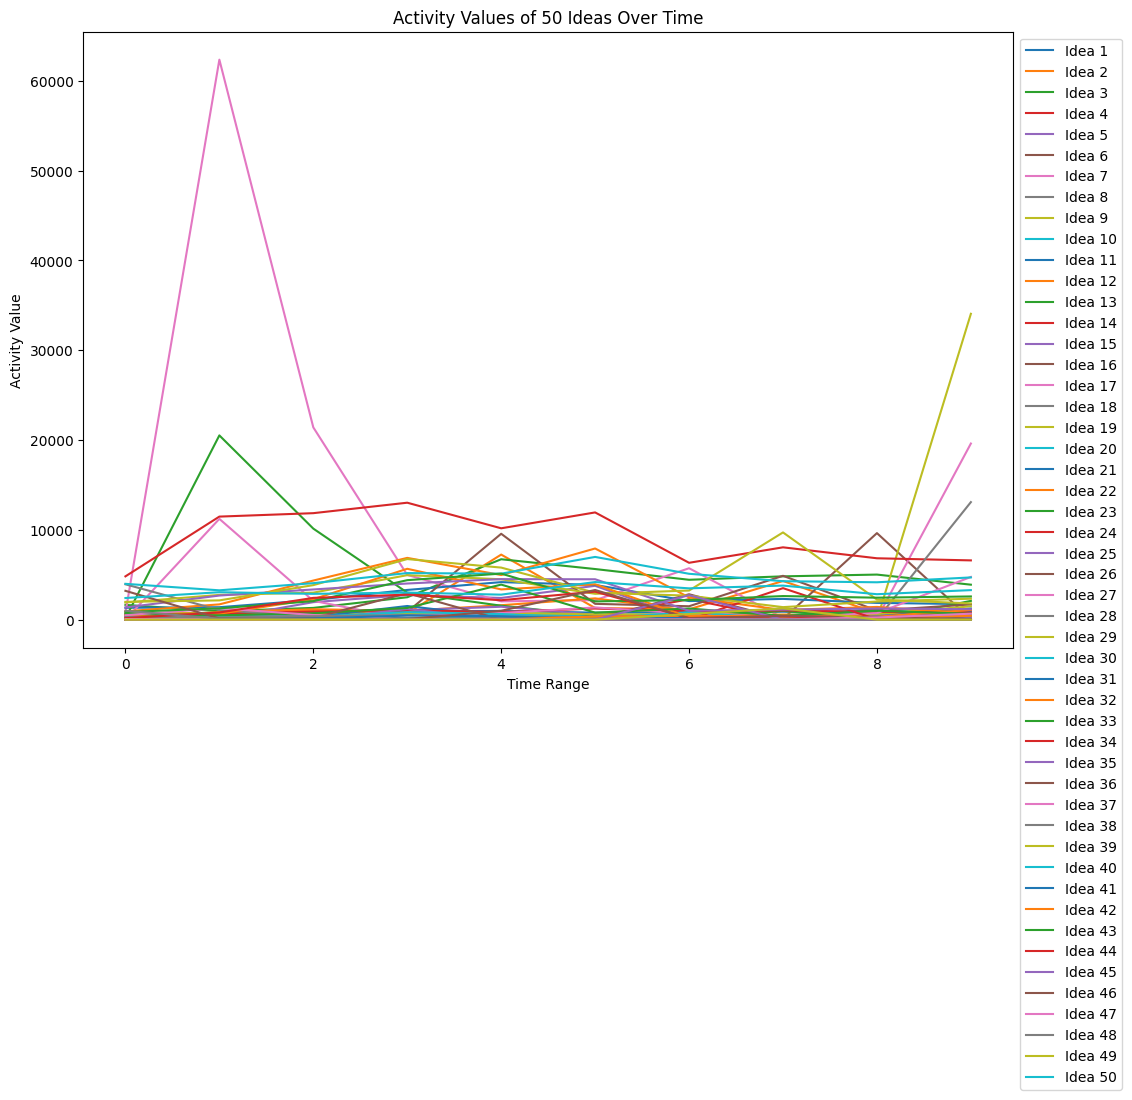

In [14]:
plt.figure(figsize=(12, 8))

# Assuming each column is a time range and each row is a different idea
time_ranges = np.arange(cluster_active_map.shape[1])  # 10 time ranges

for idea in cluster_active_map:
    plt.plot(time_ranges, idea)

plt.title('Activity Values of 50 Ideas Over Time')
plt.xlabel('Time Range')
plt.ylabel('Activity Value')
plt.legend(['Idea ' + str(i) for i in range(1, 51)], loc='upper left', bbox_to_anchor=(1, 1))  # Optional: Add a legend

plt.show()

In [5]:
def hashtag_user_time_map_generator(input_pickle):
    df = pd.read_pickle(input_pickle)
    hashtag_time_map = defaultdict(list)
    hashtag_user_map = defaultdict(list)
    for index, row in tqdm(df.iterrows()):
        rawTweet = row['rawTweet']
        hashtags = set(x for x in rawTweet.split() if x.startswith('#'))
        user = row['name']
        time = row['time_published']
        for hashtag in hashtags:
            hashtag_time_map[hashtag].append(time)
            hashtag_user_map[hashtag].append(user)
    return hashtag_time_map, hashtag_user_map

In [6]:
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')
model = AutoModel.from_pretrained('Twitter/twhin-bert-base')

Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def get_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)

    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the pooled output for a single embedding per input text
    return outputs.pooler_output

def clusterHashtags(hashtag_user_map_train, savingPath):
    tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')
    model = AutoModel.from_pretrained('Twitter/twhin-bert-base')
    hashtag_vector = []
    for hashtag in tqdm(hashtag_user_map_train):
        hashtag_vector.append(get_embedding(hashtag, tokenizer, model))

    numpy_embeddings_list = [tensor.detach().cpu().numpy() for tensor in hashtag_vector]
    numpy_embeddings = np.stack(numpy_embeddings_list)

    np.save('/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/embeddings.npy', numpy_embeddings)

    loaded_embeddings = np.load('/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/embeddings.npy')
    reshaped_array = np.squeeze(loaded_embeddings, axis=1)
    n_clusters = 50
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
    kmeans.fit(reshaped_array)

    clusters = kmeans.labels_
    cluster_to_hashtags = defaultdict(list)
    for hashtag, cluster_label in zip(list(hashtag_user_map_train.keys()), clusters):
        cluster_to_hashtags[int(cluster_label)].append(hashtag)
    
    with open(savingPath, 'w') as f:
        json.dump(cluster_to_hashtags, f)
    pass

In [8]:
def user_time_cluster_engagement_generator(input_pickle, hashtag_clusters_path, savingPath):
    with open(hashtag_clusters_path, 'r') as f:
        hashtag_clusters = json.load(f)
    element_to_cluster = {element: cluster_id for cluster_id, elements in hashtag_clusters.items() for element in elements}

    df = pd.read_pickle(input_pickle)
    
    user_cluster_time_map = defaultdict(lambda: defaultdict(list))
    for index, row in tqdm(df.iterrows()):
        rawTweet = row['rawTweet']
        hashtags = set(x for x in rawTweet.split() if x.startswith('#'))
        user = row['name']
        time = row['time_published']
        for hashtag in hashtags:
            cluster_id = element_to_cluster.get(hashtag, None)
            if cluster_id:
                user_cluster_time_map[user][int(cluster_id)].append(time)
    
    with open(savingPath, 'w') as f:
        json.dump(user_cluster_time_map, f)
    
    pass

In [9]:
def cluster_time_map_to_train(cluster, time_first, time_last):
    time_gap = time_last - time_first + 1
    result = np.zeros(13)
    for timestamp in cluster:
        time_diff = timestamp - time_first
        timeId = time_diff * 13 / time_gap
        result[int(timeId)] += 1
    result = np.where(result > 0, 1, 0)
    return result

def logReg_dataset_prep(user_cluster_time_map_path, time_first, time_last, x_save, y_save):
    with open(user_cluster_time_map_path, 'r') as f:
        user_cluster_time_map = json.load(f)
    
    x_train = np.zeros((len(user_cluster_time_map) * 50, 12))
    y_train = np.zeros(len(user_cluster_time_map) * 50)
    index = -1
    for user in tqdm(user_cluster_time_map):
        index += 1
        for cluster_id in user_cluster_time_map[user]:
            cluster = user_cluster_time_map[user][cluster_id]
            array = cluster_time_map_to_train(cluster, time_first, time_last)
            row_id = int(cluster_id) + 50*index
            x_train[row_id] = array[:12]
            y_train[row_id] = np.max(array[12:])
    
    np.save(x_save, x_train)
    np.save(y_save, y_train)
    pass


In [11]:
hashtag_time_train, hashtag_user_map = hashtag_user_time_map_generator("/home/dayouwu2/event_detection/event_detection_twitter/artifact_dir/temp_output/input_file.pkl")

3584175it [02:56, 20309.95it/s]


In [13]:
filtered_hashtag_Hamas_Israel= {key: value for key, value in hashtag_user_map.items() if len(value) > 2000}
print(len(filtered_hashtag_Hamas_Israel))

183


In [18]:
group_similar_hashtags(filtered_hashtag_Hamas_Israel)

100%|██████████| 183/183 [00:59<00:00,  3.10it/s]


True

In [19]:
user_time_cluster_engagement_generator("/home/dayouwu2/event_detection/event_detection_twitter/artifact_dir/temp_output/input_file.pkl", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/hashtag_clusters_new.json", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/user_time_cluster_map.json")

3584175it [03:08, 19019.83it/s]


In [20]:
x_save = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/x_train.npy"
y_save = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/y_train.npy"
logReg_dataset_prep("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/user_time_cluster_map.json", time_first, time_last, x_save, y_save)

100%|██████████| 436456/436456 [00:20<00:00, 21794.67it/s]


In [21]:
def logReg_classifier(x_train, y_train, x_test, y_test):
    model = LogisticRegression()

    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"accuracy: {accuracy}")

Testing Dataset Preparation (French Election)

In [6]:
with open("/home/dayouwu2/event_detection/test_us_china_conflict2/french_task/input.json", 'r') as f:
    french_input = json.load(f)

print(french_input[0])

{'content': "5f8c603455fbe57a13b212ea82b504e8090dde7b RT @ZemmourEric Proposal 4: Promoting the emergence of euro stables by the European private sector without waiting for the ECB's digital euro project, so as not to leave the monopoly of stables to non-European entities. (5/5)", 'timestamp': 1644883202}


In [8]:
with open("/home/dayouwu2/event_detection/incas_Phase1B/case_study/input_files/dataori.json", 'r') as f:
    dataori = json.load(f)

In [9]:
import re

new_dict_list = []
for entry in tqdm(dataori):
    if not entry['translatedContentText']:
        continue
    input_row = {}
    userName = entry['mediaTypeAttributes']['twitterData']['twitterAuthorScreenname']
    original_content = entry['translatedContentText']
    new_content = re.sub(r'//t\.co/\S+', '', original_content)
    input_row["rawTweet"] = new_content    
    input_row["time_published"] = int(int(entry['timePublished']) / 1000)
    input_row["name"] = userName
    new_dict_list.append(input_row)

input_df = pd.DataFrame(new_dict_list)
input_df.to_pickle("french_election_testing/input_file.pkl")

100%|██████████| 3195579/3195579 [00:06<00:00, 484458.01it/s]


In [25]:
savingPath_train = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/hashtag_eval_train.pkl"
savingPath_test = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/hashtag_eval_test.pkl"
time_first_, time_last_ = dataset_spliter("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/input_file.pkl", savingPath_train, savingPath_test)
print(time_first_, time_last_)

1644883202 1649649599


In [26]:
hashtag_time_train, hashtag_user_map = hashtag_user_time_map_generator("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/input_file.pkl")

3057159it [02:27, 20669.39it/s]


In [27]:
filtered_hashtag_user= {key: value for key, value in hashtag_user_map.items() if len(value) > 2000}
print(len(filtered_hashtag_user))

227


In [29]:
group_similar_hashtags(filtered_hashtag_user)

100%|██████████| 227/227 [00:22<00:00, 10.07it/s]


True

In [24]:
clusterHashtags(filtered_hashtag_user, "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/hashtag_clusters.json")

100%|██████████| 227/227 [00:09<00:00, 24.11it/s]
/home/dayouwu2/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
user_time_cluster_engagement_generator("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/input_file.pkl", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/hashtag_clusters_new.json", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/user_time_cluster_map.json")

3057159it [02:33, 19879.92it/s]


In [32]:
x_save_ = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/x_train.npy"
y_save_ = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/y_train.npy"
logReg_dataset_prep("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/user_time_cluster_map.json", time_first_, time_last_, x_save_, y_save_)

100%|██████████| 136176/136176 [00:07<00:00, 19165.99it/s]


Testing

In [33]:
x_test = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/x_train.npy")
y_test = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/y_train.npy")
x_train = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/x_train.npy")
y_train = np.load("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/Hamas_Isreal_Testing/y_train.npy")

In [34]:
logReg_classifier(x_train, y_train, x_test, y_test)

accuracy: 0.982645400070497


Testing Dataset Prep (2a_wtext)

In [18]:
savingPath_train = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/hashtag_eval_train.pkl"
savingPath_test = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/hashtag_eval_test.pkl"
time_first_, time_last_ = dataset_spliter("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/testing_input.pkl", savingPath_train, savingPath_test)
print(time_first_, time_last_)

1672531200 1687996755


In [14]:
hashtag_time_train, hashtag_user_map = hashtag_user_time_map_generator("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/testing_input.pkl")

126204it [00:06, 21710.31it/s]

4726147it [03:51, 20421.69it/s]


In [15]:
filtered_hashtag_user= {key: value for key, value in hashtag_user_map.items() if len(value) > 1000}
print(len(filtered_hashtag_user))

231


In [31]:
clusterHashtags(filtered_hashtag_user, "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/hashtag_clusters.json")

100%|██████████| 231/231 [00:09<00:00, 24.62it/s]
/home/dayouwu2/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
user_time_cluster_engagement_generator("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/testing_input.pkl", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/hashtag_clusters_new.json", "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/user_time_cluster_map.json")

4726147it [03:51, 20374.24it/s]


In [19]:
x_save_ = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/x_train.npy"
y_save_ = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/y_train.npy"
logReg_dataset_prep("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/2a_wtext_testing/user_time_cluster_map.json", time_first_, time_last_, x_save_, y_save_)

100%|██████████| 202789/202789 [00:04<00:00, 41062.61it/s]


In [3]:
(1687996755 - 1672531200) / 1209600

12.785677083333333

Traditional Method

In [28]:
#Traditional hashtag group methods:
def group_similar_hashtags(filtered, saving_path = "/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/hashtag_clusters_new.json"):

    #Calculate user delta value
    def median(nums):
        sorted_nums = sorted(nums)
        n = len(sorted_nums)

        if n % 2 == 0:
            return (sorted_nums[n//2 - 1] + sorted_nums[n//2]) / 2
        else:
            return sorted_nums[n//2]
        
    def makeUserMessageMap(filepath):
        data = pd.read_pickle(filepath)
        user_message_map = {}
        userName_list = data['name'].to_list()
        for userName in userName_list:
            if userName not in user_message_map:
                user_message_map[userName] = 1
            else:
                user_message_map[userName] += 1
        return user_message_map
    
    user_message_map = makeUserMessageMap("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/input_file.pkl")
    # with open("/home/dayouwu2/event_detection_Wally/hashtag_evaluation/french_election_testing/user_message_map.json", 'w') as f:
    #     json.dump(user_message_map, f)
    
    hashtag_userMessage_map = {}
    user_involved_total = []

    for hashtag in filtered:
        users_involved = hashtag_user_map[hashtag]
        user_involved_total += users_involved
        hashtag_userMessage_map[hashtag] = {}
        hashtag_userMessage_map[hashtag]['users'] = users_involved
        hashtag_userMessage_map[hashtag]['user_messages_count'] = []
        for user in users_involved:
            user_messages = user_message_map[user]
            hashtag_userMessage_map[hashtag]['user_messages_count'].append(user_messages)

    user_total_set = set(user_involved_total)

    # Calculate hashtag delta value
    for hashtag in tqdm(hashtag_userMessage_map):
        user_messages = hashtag_userMessage_map[hashtag]['user_messages_count']
        user_involved = hashtag_userMessage_map[hashtag]['users']
        user_involved_set = set(user_involved)
        user_not_involved = list(user_total_set - user_involved_set)
        # user_not_involved = [x for x in user_involved_total if x not in user_involved]

        user_not_messages = []
        for user in user_not_involved:
            message_count = user_message_map[user]
            user_not_messages.append(message_count)
            
        in_median = median(user_messages)
        no_median = median(user_not_messages)
        delta = in_median - no_median
        hashtag_userMessage_map[hashtag]['delta'] = delta
    
    hashtag_userMessage_map = dict(sorted(hashtag_userMessage_map.items(), key=lambda item:item[1]['delta'], reverse=True))
    first_50_hashtags = dict(islice(hashtag_userMessage_map.items(), 50))
    lead_hashtags = {}
    lead_list = list(first_50_hashtags.keys())
    for hashtag in lead_list:
        lead_hashtags[hashtag] = []
    for index, hashtag in enumerate(list(filtered.keys())):
        if hashtag in lead_list:
            continue
        else:
            similarity = np.zeros(50)
            for index, lead_tag in enumerate(lead_list):
                distance = Levenshtein.distance(hashtag, lead_tag)
                similarity[index] = 1 - (distance / max(len(hashtag), len(lead_tag)))
            max_index = similarity.argmax()
            lead_hashtag = lead_list[max_index]
            lead_hashtags[lead_hashtag].append(hashtag)
    
    top50_hashtagGroups = defaultdict(list)
    for index, lead_hashtag in enumerate(lead_hashtags):
        top50_hashtagGroups[index] = [lead_hashtag] + lead_hashtags[lead_hashtag]
    
    with open(saving_path, 'w') as f:
        json.dump(top50_hashtagGroups, f)

    return True

In [16]:
group_similar_hashtags(filtered_hashtag_user)

100%|██████████| 231/231 [00:28<00:00,  8.08it/s]


True